# Anomaly Detection

In [34]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [35]:
data = pd.read_csv('/content/ambient_temperature_system_failure.csv')

data_values = data.drop('timestamp',
                        axis=1).values

data_values = data_values.astype('float32')

data_converted = pd.DataFrame(data_values,
                              columns=data.columns[1:])

data_converted.insert(0, 'timestamp',
                      data['timestamp'])

In [36]:
data_converted = data_converted.dropna()

In [37]:
data_tensor = tf.convert_to_tensor(data_converted.drop(
    'timestamp', axis=1).values, dtype=tf.float32)

input_dim = data_converted.shape[1] - 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True)

reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2557.4524
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 306.9787
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6777
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0016
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0015
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 12/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015
Epoch 13/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 14/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 15/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [38]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

In [39]:
test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


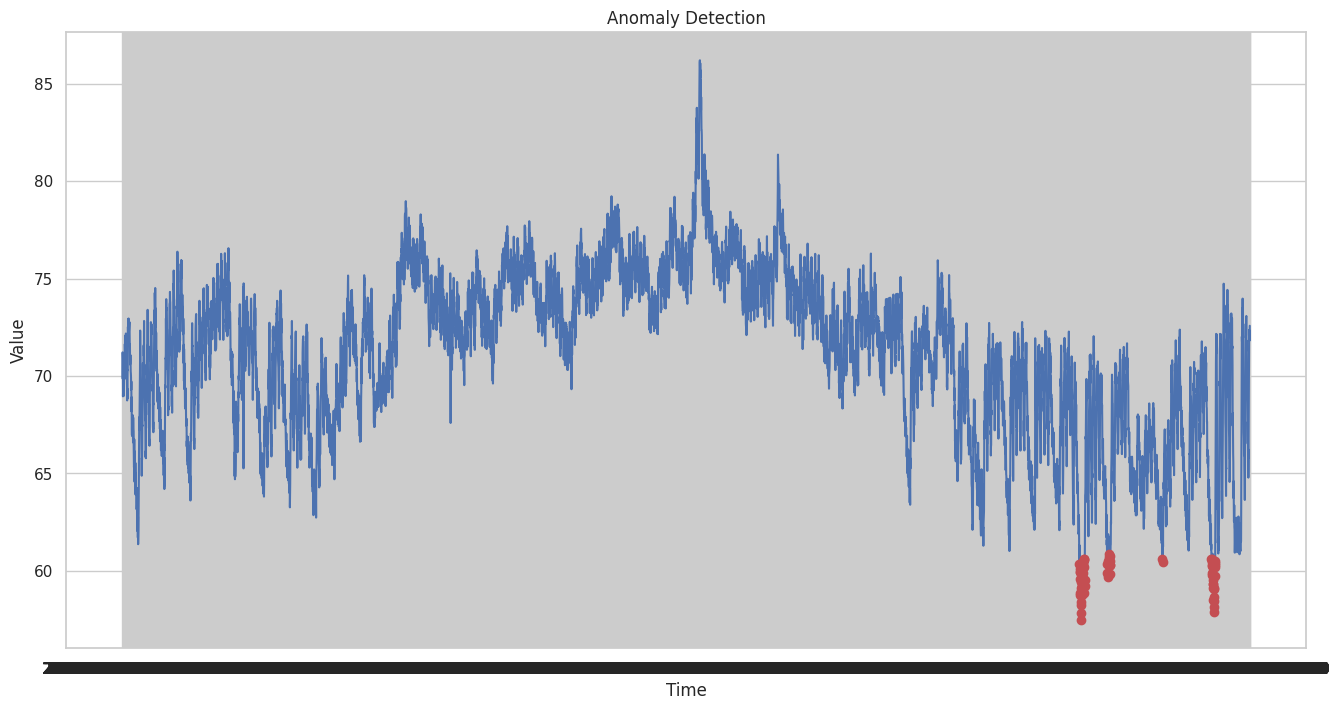

In [41]:
plt.figure(figsize=(16, 8))

plt.plot(data_converted['timestamp'], data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous], data_converted['value'][anomalous], 'ro')

plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')

plt.show()